In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("rocket")
# sns.color_palette("flare")

In [2]:
df = pd.read_csv("/kaggle/input/weather-prediction/seattle-weather.csv",index_col="date",parse_dates=True)
df_temp = df["temp_max"]

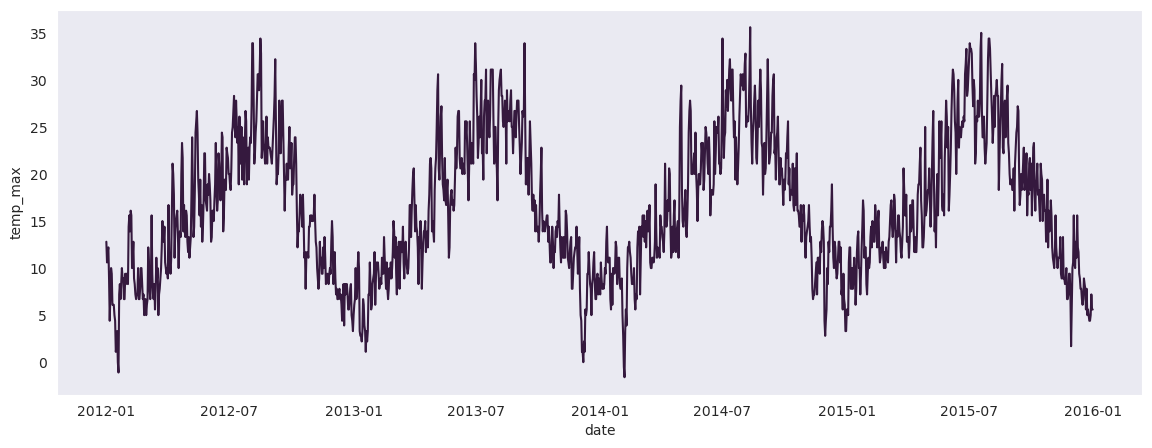

In [43]:
plt.figure(figsize=(14,5))
sns.lineplot(df_temp);

In [4]:
def df_to_XY(df,window_size=10):
    df_np = df_temp.to_numpy()
    X = []
    y = []
    for i in range(len(df_np)-window_size):
        row = [[a] for a in df_np[i:i+window_size]]
        X.append(row)
        target = df_np[i+window_size]
        y.append(target)
    return np.array(X),np.array(y)
        

In [5]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [6]:
X.shape

(1451, 10, 1)

# Model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [8]:
model = Sequential()
model.add(LSTM(64,input_shape=(WINDOW,1)))
model.add(Dense(32,"relu"))
model.add(Dropout(0.2))
model.add(Dense(16,"relu"))
model.add(Dense(1,"linear"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [9]:
callback1 = ModelCheckpoint('model/',save_best_only=True)
earlyStopping = EarlyStopping(monitor="val_root_mean_squared_error",patience=3,start_from_epoch=5,restore_best_weights=True,)
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=RootMeanSquaredError())

In [10]:
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100, callbacks=[earlyStopping])

Epoch 1/100
25/25 [==============================] - 4s 36ms/step - loss: 294.8714 - root_mean_squared_error: 17.1718 - val_loss: 513.4009 - val_root_mean_squared_error: 22.6584
Epoch 2/100
25/25 [==============================] - 0s 9ms/step - loss: 286.4207 - root_mean_squared_error: 16.9240 - val_loss: 502.0854 - val_root_mean_squared_error: 22.4073
Epoch 3/100
25/25 [==============================] - 0s 9ms/step - loss: 281.3087 - root_mean_squared_error: 16.7723 - val_loss: 495.7188 - val_root_mean_squared_error: 22.2647
Epoch 4/100
25/25 [==============================] - 0s 9ms/step - loss: 276.7041 - root_mean_squared_error: 16.6344 - val_loss: 490.3790 - val_root_mean_squared_error: 22.1445
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 270.1456 - root_mean_squared_error: 16.4361 - val_loss: 479.5144 - val_root_mean_squared_error: 21.8978
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 262.7119 - root_mean_squared_error: 16.

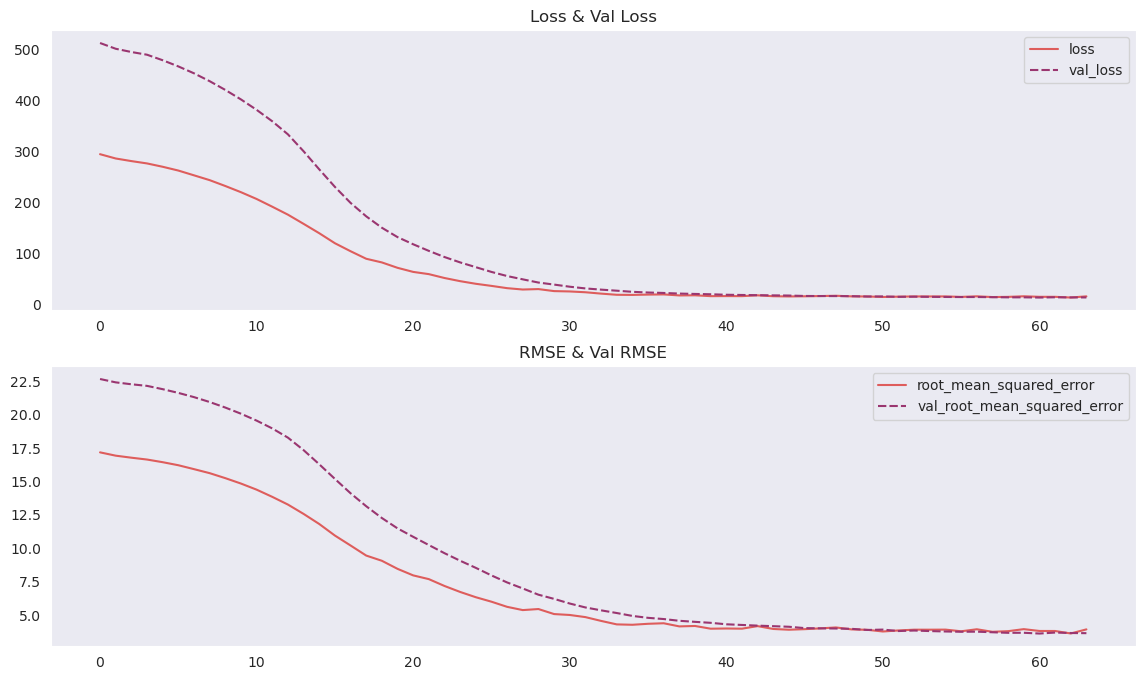

In [11]:
his = pd.DataFrame(history.history)
his.columns
history_loss = his[['loss', 'val_loss']]
history_rmse =  his[['root_mean_squared_error', 'val_root_mean_squared_error']]

fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");

plt.subplot(2,1,2)
plt.title("RMSE & Val RMSE")
sns.lineplot(history_rmse,palette="flare");

# Evaluation

In [12]:
train_pred = model.predict(X_train).flatten()
val_pred = model.predict(X_val).flatten()
test_pred = model.predict(X_test).flatten()

15/15 [==============================] - 0s 3ms/step


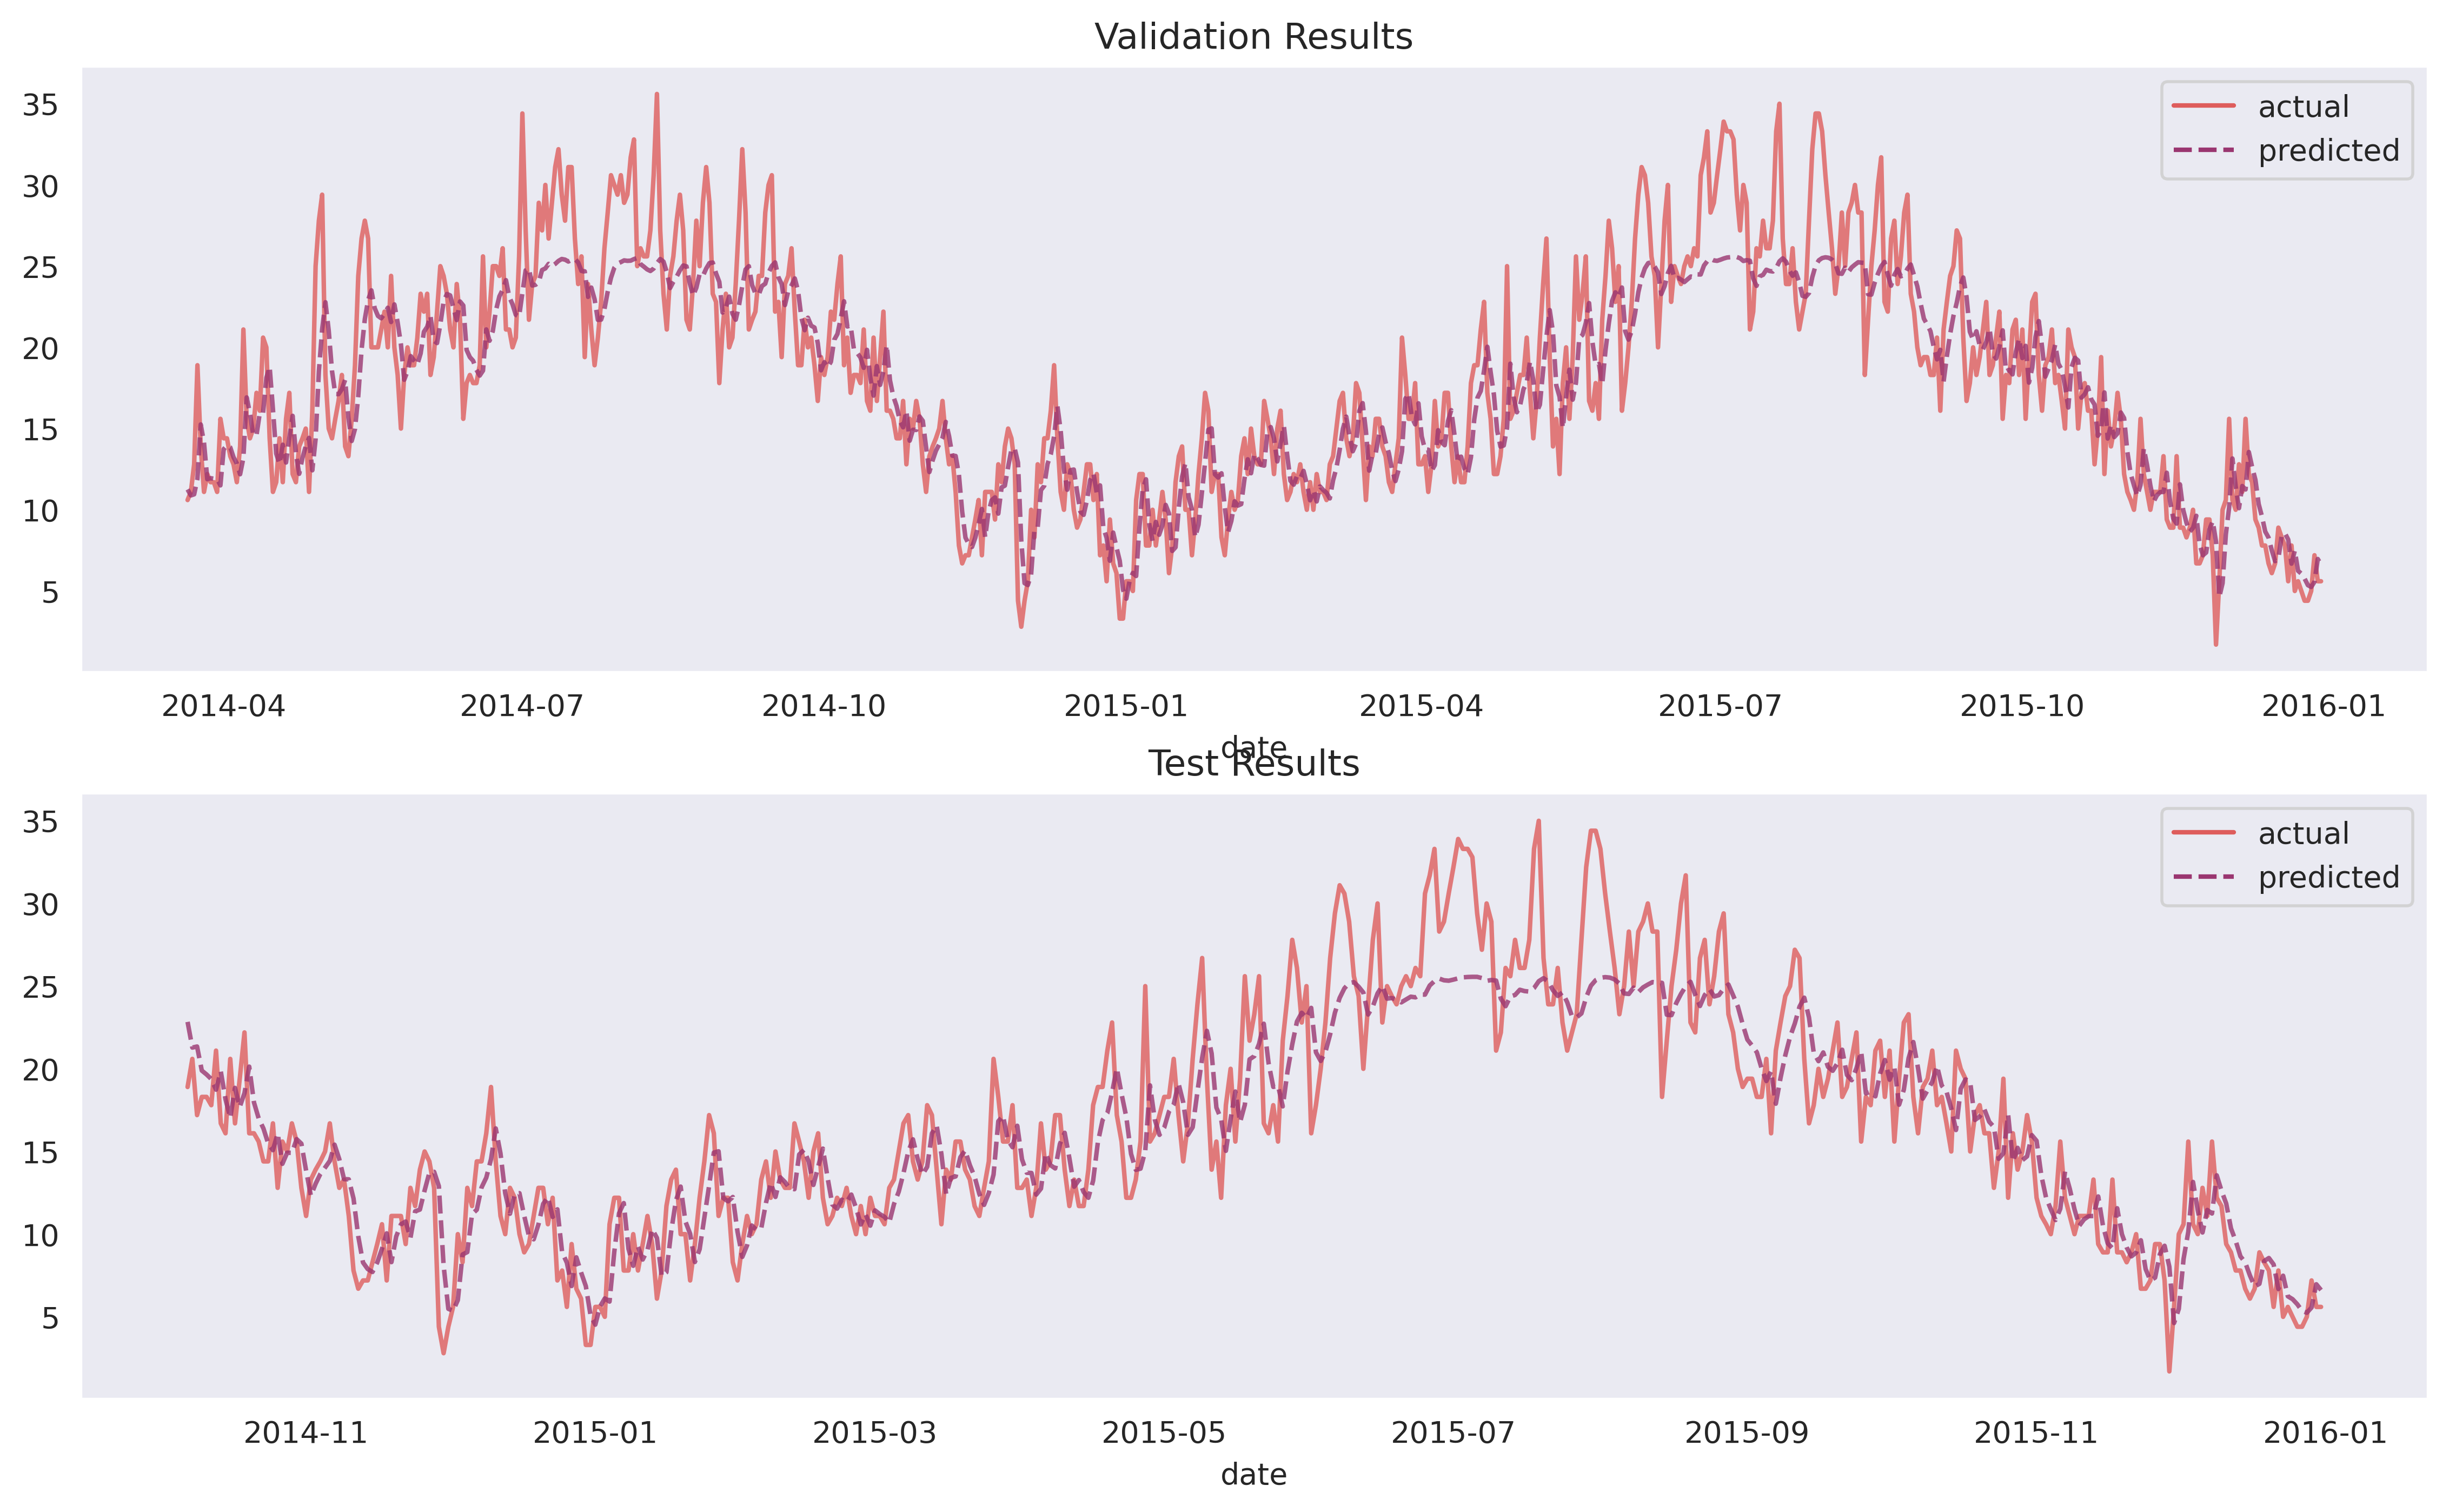

In [42]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);